deepinfra-deepseek_ai -> (0.32, 0.89)
deepinfra-meta_llama -> (0.1, 0.32)
deepinfra-qwen -> (0.12, 0.39)
deepinfra-qwen3 -> (0.08, 0.24)
deepinfra-microsoft_phi -> (0.07, 0.14)
deepinfra-claude-4-sonnet -> (3.3, 16.5)
deepinfra-mistralaiSmall -> (0.075, 0.2)
deepinfra-Qwen3-235B-A22B-Thinking-2507 -> (0.23, 2.39)
deepinfra-gemini-2.5-pro -> (1.25, 10.0)
Loaded 8,742 rows, 94 columns

Rows per Method:
Method
Direct (Non-Reasoning)    2394
Prompt2DAG (Template)     1578
Prompt2DAG (LLM)          2043
Prompt2DAG (Hybrid)       2043
Direct (Reasoning)         684
Name: count, dtype: int64

Top LLM_for_Workflow values:
LLM_for_Workflow
deepinfra-qwen3                            1368
deepinfra-claude-4-sonnet                  1257
deepinfra-mistralaiSmall                   1212
deepinfra-qwen                             1128
deepinfra-meta_llama                       1104
deepinfra-deepseek_ai                      1050
deepinfra-microsoft_phi                     939
deepinfra-gemini-2.5-pro 

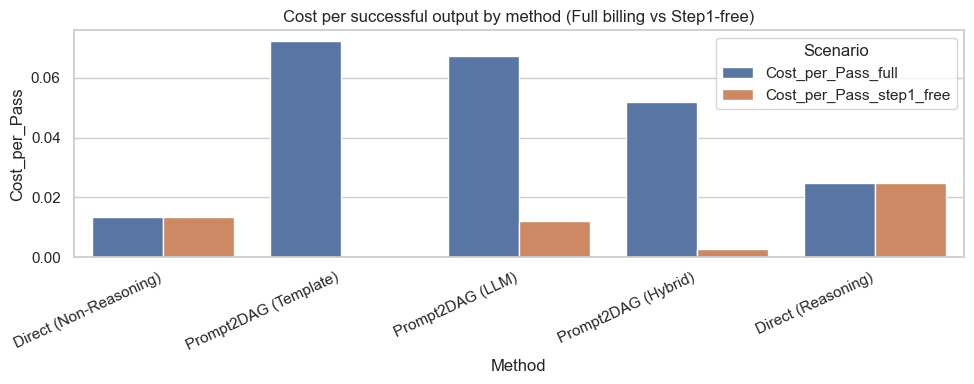

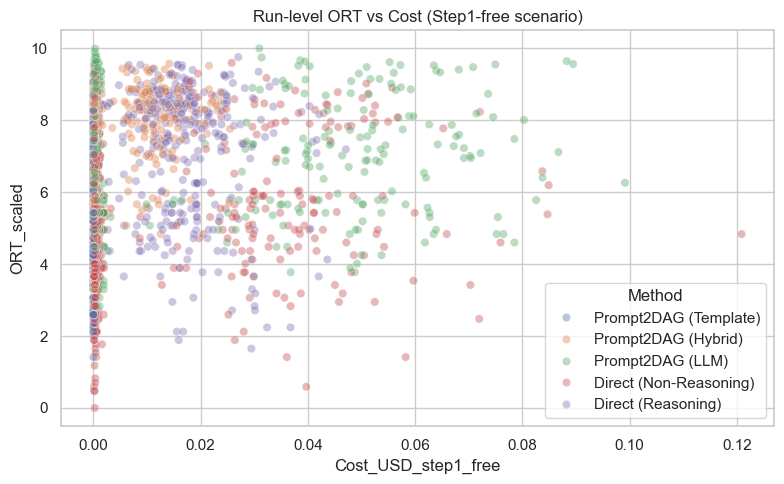

TABLE A1 (optional): LLM_for_Workflow × Method (tokens/cost/quality)
                       LLM_for_Workflow                 Method   N  Avg_Tokens  Avg_Cost_full  Avg_Cost_step1_free  Avg_ORT  Avg_Combined  Pass%
deepinfra-Qwen3-235B-A22B-Thinking-2507     Direct (Reasoning) 342   6552.4620         0.0140               0.0140   7.0979        5.9370   71.1
              deepinfra-claude-4-sonnet Direct (Non-Reasoning) 342   2925.4444         0.0369               0.0369   6.1076        5.1255   49.1
              deepinfra-claude-4-sonnet  Prompt2DAG (Template) 249  27798.2490         0.2085               0.0000   6.3852        4.2915   55.4
              deepinfra-claude-4-sonnet       Prompt2DAG (LLM) 333  32418.5796         0.2648               0.0495   6.8856        6.0261   66.7
              deepinfra-claude-4-sonnet    Prompt2DAG (Hybrid) 333  30242.9189         0.2271               0.0121   8.0012        6.4692   94.6
                  deepinfra-deepseek_ai Direct (Non-Reasoning

In [1]:
# %% [markdown]
# # Token & Cost–Benefit Analysis Across 5 Methodologies (all_sessions_cleaned.csv)
#
# Methods:
# 1. Direct (Non-Reasoning)
# 2. Prompt2DAG (Template)
# 3. Prompt2DAG (LLM)
# 4. Prompt2DAG (Hybrid)
# 5. Direct (Reasoning)
#
# Cost models:
# - Scenario A (FULL): bill all method-used tokens
# - Scenario B (STEP1-FREE): Prompt2DAG Step1 uses a free LLM => Step1 cost = 0
#
# Key outputs:
# - Tokens per method (Step1 vs Step3)
# - Cost per run and total cost per method
# - Cost per successful run (expected cost to get one passing output)
# - Efficiency: ORT-per-dollar and dollars-per-ORT
# - Optional appendix: breakdown by LLM and orchestrator

# %%
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 220)
pd.set_option("display.width", 240)

# %% [markdown]
# ## 0) Paths & configuration

# %%
CSV_PATH = "/Users/abubakarialidu/Desktop/Data Result/all_sessions_cleaned.csv"

METHOD_ORDER = [
    "Direct (Non-Reasoning)",
    "Prompt2DAG (Template)",
    "Prompt2DAG (LLM)",
    "Prompt2DAG (Hybrid)",
    "Direct (Reasoning)",
]

ORCH_ORDER = ["airflow", "dagster", "prefect"]

# ORT weights (match your main analysis)
ALPHA_CRIT = 2.0
BETA_MAJOR = 1.0
GAMMA_MINOR = 0.25

# %% [markdown]
# ## 1) LLM pricing (USD per 1M tokens)
#
# You provided:
#
# **Standard LLMs**
# - deepinfra:deepseek_ai        $0.32 in,  $0.89 out
# - deepinfra:meta_llama         $0.10 in,  $0.32 out
# - deepinfra:qwen               $0.12 in,  $0.39 out
# - deepinfra:qwen3              $0.08 in,  $0.24 out
# - deepinfra:microsoft_phi      $0.07 in,  $0.14 out
# - deepinfra:claude-4-sonnet    $3.30 in, $16.50 out
# - deepinfra:mistralaiSmall     $0.075 in, $0.20 out
#
# **Reasoning LLMs**
# - deepinfra:Qwen3-235B-A22B-Thinking-2507  $0.23 in, $2.39 out
# - deepinfra:gemini-2.5-pro                $1.25 in, $10.00 out
#
# We'll do robust matching using normalization + substring rules.

# %%
PRICING_PER_1M = {
    # Standard
    "deepinfra-deepseek_ai": (0.32, 0.89),
    "deepinfra-meta_llama": (0.10, 0.32),
    "deepinfra-qwen": (0.12, 0.39),
    "deepinfra-qwen3": (0.08, 0.24),
    "deepinfra-microsoft_phi": (0.07, 0.14),
    "deepinfra-claude-4-sonnet": (3.30, 16.50),
    "deepinfra-mistralaiSmall": (0.075, 0.20),

    # Reasoning
    "deepinfra-Qwen3-235B-A22B-Thinking-2507": (0.23, 2.39),
    "deepinfra-gemini-2.5-pro": (1.25, 10.00),
}

def normalize_llm_name(x: str) -> str:
    """
    Normalize names to something like:
      deepinfra:meta_llama -> deepinfra-meta_llama
      deepinfra-meta_llama -> deepinfra-meta_llama
    """
    if x is None:
        return ""
    x = str(x).strip()
    x = x.replace("deepinfra:", "deepinfra-")
    x = x.replace(":", "-")
    return x

def get_pricing(llm_name: str):
    """
    Return (in_price, out_price) for the LLM.
    Uses:
    1) direct dict lookup after normalization
    2) substring fallback for common variants
    """
    llm = normalize_llm_name(llm_name)

    # 1) direct match
    if llm in PRICING_PER_1M:
        return PRICING_PER_1M[llm]

    # 2) substring fallback (order matters: more specific first)
    low = llm.lower()

    if "gemini-2.5-pro" in low:
        return PRICING_PER_1M["deepinfra-gemini-2.5-pro"]
    if "qwen3-235b" in low and "thinking" in low:
        return PRICING_PER_1M["deepinfra-Qwen3-235B-A22B-Thinking-2507"]
    if "claude-4-sonnet" in low:
        return PRICING_PER_1M["deepinfra-claude-4-sonnet"]
    if "deepseek" in low and "deepseek_ai" in low:
        return PRICING_PER_1M["deepinfra-deepseek_ai"]
    if "meta_llama" in low or "llama" in low:
        return PRICING_PER_1M["deepinfra-meta_llama"]
    if "microsoft_phi" in low or "phi" in low:
        return PRICING_PER_1M["deepinfra-microsoft_phi"]
    if "mistralai" in low or "mistralaismall" in low:
        return PRICING_PER_1M["deepinfra-mistralaiSmall"]
    # distinguish qwen3 vs qwen
    if "qwen3" in low:
        return PRICING_PER_1M["deepinfra-qwen3"]
    if "qwen" in low:
        return PRICING_PER_1M["deepinfra-qwen"]

    return (np.nan, np.nan)

# quick sanity
for k in PRICING_PER_1M.keys():
    print(k, "->", get_pricing(k))

# %% [markdown]
# ## 2) Load data + classify methods (5-method taxonomy)

# %%
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")

df["Orchestrator"] = df["Orchestrator"].astype(str).str.lower().str.strip()

# Passed -> bool
if df["Passed"].dtype != bool:
    df["Passed"] = df["Passed"].astype(str).str.lower().map({"true": True, "false": False, "1": True, "0": False})

def classify_method(row):
    workflow = row.get("Workflow", "")
    strategy = str(row.get("Strategy") or "").lower()
    if workflow == "Direct":
        return "Direct (Non-Reasoning)"
    elif workflow == "Reasoning":
        return "Direct (Reasoning)"
    elif workflow == "Prompt2DAG":
        if "template" in strategy:
            return "Prompt2DAG (Template)"
        elif "llm" in strategy:
            return "Prompt2DAG (LLM)"
        elif "hybrid" in strategy:
            return "Prompt2DAG (Hybrid)"
        else:
            return f"Prompt2DAG ({row.get('Strategy','Unknown')})"
    return workflow

df["Method"] = df.apply(classify_method, axis=1)
df = df[df["Method"].isin(METHOD_ORDER)].copy()

print("\nRows per Method:")
print(df["Method"].value_counts().reindex(METHOD_ORDER))

# %% [markdown]
# ## 3) Determine LLM_for_Workflow (Std for Direct/P2D; Reasoning_LLM for Reasoning)

# %%
for c in ["Std_LLM", "Reasoning_LLM"]:
    if c not in df.columns:
        df[c] = "unknown"

def get_llm_for_workflow(row):
    if row["Method"] == "Direct (Reasoning)":
        return normalize_llm_name(row.get("Reasoning_LLM", ""))
    return normalize_llm_name(row.get("Std_LLM", ""))

df["LLM_for_Workflow"] = df.apply(get_llm_for_workflow, axis=1)

print("\nTop LLM_for_Workflow values:")
print(df["LLM_for_Workflow"].value_counts().head(15))

# %% [markdown]
# ## 4) Token columns and step-level token accounting
#
# We will construct:
# - Step1 tokens: S1_Tokens_total_input/output (Prompt2DAG only; 0 otherwise)
# - Step3 tokens: Input_Tokens/Output_Tokens (Direct/Reasoning and Prompt2DAG LLM/Hybrid; for Template assumed 0)
#
# **Your modeling assumptions:**
# - Prompt2DAG (Template): only Step1 uses tokens; Step3 is deterministic => Step3 tokens treated as 0 for cost model
# - Prompt2DAG (LLM) / (Hybrid): Step1 + Step3 use tokens
# - Direct methods: Step3 only

# %%
# Ensure token columns exist
for col in ["Input_Tokens", "Output_Tokens", "S1_Tokens_total_input", "S1_Tokens_total_output"]:
    if col not in df.columns:
        df[col] = 0

df[["Input_Tokens", "Output_Tokens", "S1_Tokens_total_input", "S1_Tokens_total_output"]] = (
    df[["Input_Tokens", "Output_Tokens", "S1_Tokens_total_input", "S1_Tokens_total_output"]]
    .fillna(0)
)

def compute_tokens(row):
    method = row["Method"]

    # Step 1 tokens
    s1_in = float(row.get("S1_Tokens_total_input", 0.0))
    s1_out = float(row.get("S1_Tokens_total_output", 0.0))

    # Step 3 tokens as logged
    s3_in_logged = float(row.get("Input_Tokens", 0.0))
    s3_out_logged = float(row.get("Output_Tokens", 0.0))

    # Apply your method-specific assumption
    if method == "Prompt2DAG (Template)":
        # Template: Step3 is deterministic => treat as 0 for method token cost model
        s3_in = 0.0
        s3_out = 0.0
    elif method.startswith("Prompt2DAG"):
        # LLM / Hybrid: Step3 uses tokens
        s3_in = s3_in_logged
        s3_out = s3_out_logged
    else:
        # Direct / Reasoning: no Step1, everything is Step3
        s1_in, s1_out = 0.0, 0.0
        s3_in, s3_out = s3_in_logged, s3_out_logged

    method_in = s1_in + s3_in
    method_out = s1_out + s3_out

    # Also track what was logged (for sanity checks)
    observed_total = s1_in + s1_out + s3_in_logged + s3_out_logged

    return pd.Series({
        "Step1_Input": s1_in,
        "Step1_Output": s1_out,
        "Step3_Input": s3_in,
        "Step3_Output": s3_out,
        "Method_Input_Tokens": method_in,
        "Method_Output_Tokens": method_out,
        "Method_Total_Tokens": method_in + method_out,
        "Observed_Total_Tokens_logged": observed_total,
        "Step3_Input_logged": s3_in_logged,
        "Step3_Output_logged": s3_out_logged,
    })

df = pd.concat([df, df.apply(compute_tokens, axis=1)], axis=1)

df[["Method","Step1_Input","Step1_Output","Step3_Input","Step3_Output","Method_Total_Tokens"]].head(10)

# %% [markdown]
# ## 5) Compute ORT (optional, but useful for cost-benefit)
#
# We'll compute ORT_scaled consistent with your main analysis approach (global min-max on ORT_raw).
# This helps create metrics like "ORT per dollar" and "expected cost per ORT point".

# %%
for c in ["Critical_Issues", "Major_Issues", "Minor_Issues"]:
    if c not in df.columns:
        df[c] = 0
    df[c] = df[c].fillna(0)

df["Total_Issues"] = df["Critical_Issues"] + df["Major_Issues"] + df["Minor_Issues"]

df["Base_Score"] = np.where(df["Passed"] == True, df["Combined_Score"], 0.0)
df["Penalty"] = (
    ALPHA_CRIT * df["Critical_Issues"] +
    BETA_MAJOR * df["Major_Issues"] +
    GAMMA_MINOR * df["Minor_Issues"]
)
df["ORT_raw"] = df["Base_Score"] - df["Penalty"]

ort_min, ort_max = df["ORT_raw"].min(), df["ORT_raw"].max()
df["ORT_scaled"] = 0.0
if ort_max > ort_min:
    df["ORT_scaled"] = 10.0 * (df["ORT_raw"] - ort_min) / (ort_max - ort_min)

print(df[["Combined_Score","ORT_scaled"]].corr().round(3).to_string())

# %% [markdown]
# ## 6) Cost computation under two scenarios
#
# - Scenario A: FULL billing
# - Scenario B: Step1 FREE for Prompt2DAG (Template/LLM/Hybrid)
#
# Cost per run:
#   cost = in_tokens/1e6 * in_price + out_tokens/1e6 * out_price

# %%
def cost_from_tokens(llm, in_tokens, out_tokens):
    in_price, out_price = get_pricing(llm)
    if np.isnan(in_price) or np.isnan(out_price):
        return np.nan
    return (in_tokens / 1_000_000.0) * in_price + (out_tokens / 1_000_000.0) * out_price

def compute_costs(row):
    method = row["Method"]
    llm = row["LLM_for_Workflow"]

    # Scenario A: FULL billing uses method tokens as defined earlier
    full_in = float(row["Method_Input_Tokens"])
    full_out = float(row["Method_Output_Tokens"])
    cost_full = cost_from_tokens(llm, full_in, full_out)

    # Scenario B: Step1 is FREE for Prompt2DAG methods
    if method.startswith("Prompt2DAG"):
        free_in = float(row["Step3_Input"])   # bill only step3
        free_out = float(row["Step3_Output"])
    else:
        free_in = full_in
        free_out = full_out

    cost_step1_free = cost_from_tokens(llm, free_in, free_out)

    return pd.Series({
        "Cost_USD_full": cost_full,
        "Cost_USD_step1_free": cost_step1_free,
        "Billed_Input_full": full_in,
        "Billed_Output_full": full_out,
        "Billed_Input_step1_free": free_in,
        "Billed_Output_step1_free": free_out,
    })

df = pd.concat([df, df.apply(compute_costs, axis=1)], axis=1)

print("Non-null cost_full rows:", df["Cost_USD_full"].notna().sum())
print("Non-null cost_step1_free rows:", df["Cost_USD_step1_free"].notna().sum())

# %% [markdown]
# ## 7) Sanity checks
# - Template should have Step3 tokens = 0 in the *model*
# - Under Step1-free scenario, Template should cost ~0

# %%
tmp = df[df["Method"] == "Prompt2DAG (Template)"].copy()
print("Template: mean Step3_Input (model) =", tmp["Step3_Input"].mean())
print("Template: mean Cost_step1_free    =", tmp["Cost_USD_step1_free"].mean())

# %% [markdown]
# ## 8) Table C1: Tokens & Cost by Method (ALL runs)
#
# Includes:
# - Pass rate
# - Mean tokens (Step1 vs Step3 vs total)
# - Mean cost under full vs step1-free
# - Total spend in experiment
# - Mean ORT / Combined to support cost-benefit discussion
# - Expected cost per success: total_cost / number_of_passed_runs

# %%
def summarize_by_method(df_in: pd.DataFrame, label: str):
    rows = []
    for m in METHOD_ORDER:
        sub = df_in[df_in["Method"] == m].copy()
        if len(sub) == 0:
            continue

        n = len(sub)
        n_pass = int(sub["Passed"].sum())
        pass_rate = sub["Passed"].mean()

        # totals (for expected cost per success)
        total_cost_full = sub["Cost_USD_full"].sum()
        total_cost_free = sub["Cost_USD_step1_free"].sum()

        row = {
            "Method": m,
            "N": n,
            "N_Passed": n_pass,
            "Pass%": 100*pass_rate,

            "Avg_Step1_Tokens": (sub["Step1_Input"] + sub["Step1_Output"]).mean(),
            "Avg_Step3_Tokens": (sub["Step3_Input"] + sub["Step3_Output"]).mean(),
            "Avg_Total_Tokens": sub["Method_Total_Tokens"].mean(),

            "Avg_Cost_full": sub["Cost_USD_full"].mean(),
            "Total_Cost_full": total_cost_full,

            "Avg_Cost_step1_free": sub["Cost_USD_step1_free"].mean(),
            "Total_Cost_step1_free": total_cost_free,

            # Cost to obtain one passing output (empirical):
            "Cost_per_Pass_full": (total_cost_full / n_pass) if n_pass > 0 else np.nan,
            "Cost_per_Pass_step1_free": (total_cost_free / n_pass) if n_pass > 0 else np.nan,

            # Quality indicators
            "Avg_Combined": sub["Combined_Score"].mean(),
            "Avg_ORT_scaled": sub["ORT_scaled"].mean(),
        }
        rows.append(row)

    out = pd.DataFrame(rows)
    # formatting
    for c in out.columns:
        if c not in ["Method"]:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    out = out.round(4)
    print("\n" + "="*120)
    print(label)
    print("="*120)
    print(out.to_string(index=False))
    return out

table_all = summarize_by_method(df, "TABLE C1: TOKENS & COST BY METHOD (ALL RUNS)")

# %% [markdown]
# ## 9) Table C2: Tokens & Cost by Method (PASSED runs only)
#
# This answers: "When a method succeeds, how expensive is it per successful output and how good is it?"

# %%
df_passed = df[df["Passed"] == True].copy()
table_passed = summarize_by_method(df_passed, "TABLE C2: TOKENS & COST BY METHOD (PASSED RUNS ONLY)")

# %% [markdown]
# ## 10) Cost-benefit metrics (paper-friendly)
#
# These are often more interpretable:
# - ORT per $ (higher is better)
# - $ per ORT point (lower is better)
# - expected $ per passing output (already computed above)
#
# We'll compute these for BOTH scenarios, using ALL runs.

# %%
cb = table_all.copy()

# Guard against division by zero
cb["ORT_per_$ (full)"] = cb["Avg_ORT_scaled"] / cb["Avg_Cost_full"].replace(0, np.nan)
cb["ORT_per_$ (step1free)"] = cb["Avg_ORT_scaled"] / cb["Avg_Cost_step1_free"].replace(0, np.nan)

cb["$ per ORT (full)"] = cb["Avg_Cost_full"] / cb["Avg_ORT_scaled"].replace(0, np.nan)
cb["$ per ORT (step1free)"] = cb["Avg_Cost_step1_free"] / cb["Avg_ORT_scaled"].replace(0, np.nan)

# Also a "quality per pass-dollar" proxy: ORT / cost_per_pass
cb["ORT per $ of success (full)"] = cb["Avg_ORT_scaled"] / cb["Cost_per_Pass_full"].replace(0, np.nan)
cb["ORT per $ of success (step1free)"] = cb["Avg_ORT_scaled"] / cb["Cost_per_Pass_step1_free"].replace(0, np.nan)

cb = cb.round(4)

print("="*120)
print("TABLE C3: COST–BENEFIT METRICS (ALL RUNS, method-level)")
print("="*120)
print(cb[[
    "Method","N","Pass%","Avg_ORT_scaled",
    "Avg_Cost_full","Cost_per_Pass_full","ORT_per_$ (full)","$ per ORT (full)",
    "Avg_Cost_step1_free","Cost_per_Pass_step1_free","ORT_per_$ (step1free)","$ per ORT (step1free)"
]].to_string(index=False))

# %% [markdown]
# ## 11) Prompt2DAG Step1 vs Step3 token share
#
# This is important to justify the "Step1-free" scenario impact.

# %%
p2d = df[df["Method"].str.startswith("Prompt2DAG")].copy()
p2d["Step1_Total"] = p2d["Step1_Input"] + p2d["Step1_Output"]
p2d["Step3_Total"] = p2d["Step3_Input"] + p2d["Step3_Output"]
p2d["Step1_Share"] = p2d["Step1_Total"] / (p2d["Step1_Total"] + p2d["Step3_Total"]).replace(0, np.nan)

step_break = (
    p2d.groupby("Method")[["Step1_Total","Step3_Total","Step1_Share"]]
    .mean()
    .reindex([m for m in METHOD_ORDER if m.startswith("Prompt2DAG")])
    .round(4)
)

print("="*120)
print("TABLE C4: Prompt2DAG Step1 vs Step3 token breakdown (means)")
print("="*120)
print(step_break.to_string())

# %% [markdown]
# ## 12) Plot: cost per successful output (full vs step1-free)
#
# This is one of the best plots for the appendix.

# %%
plot_df = table_all.copy()
plot_df = plot_df[["Method","Cost_per_Pass_full","Cost_per_Pass_step1_free","Pass%","N"]].copy()

plot_long = plot_df.melt(
    id_vars=["Method","Pass%","N"],
    value_vars=["Cost_per_Pass_full","Cost_per_Pass_step1_free"],
    var_name="Scenario", value_name="Cost_per_Pass"
)

plt.figure(figsize=(10,4))
sns.barplot(data=plot_long, x="Method", y="Cost_per_Pass", hue="Scenario")
plt.xticks(rotation=25, ha="right")
plt.title("Cost per successful output by method (Full billing vs Step1-free)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 13) Plot: ORT vs cost (run-level scatter)
#
# Useful to visually show "quality-cost" frontier.

# %%
sample = df[df["Cost_USD_step1_free"].notna()].sample(min(4000, len(df)), random_state=42)

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=sample,
    x="Cost_USD_step1_free",
    y="ORT_scaled",
    hue="Method",
    alpha=0.4
)
plt.title("Run-level ORT vs Cost (Step1-free scenario)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 14) Optional appendix: LLM × Method token/cost summary
#
# Since your main focus is methodology, this can stay in the appendix.
# This table helps you argue results are not driven by one model.

# %%
# Keep only rows with known pricing
df_known = df[df["Cost_USD_full"].notna()].copy()

llm_method = (
    df_known
    .groupby(["LLM_for_Workflow","Method"], observed=True)
    .agg(
        N=("Passed","size"),
        Pass_Rate=("Passed","mean"),
        Avg_Tokens=("Method_Total_Tokens","mean"),
        Avg_Cost_full=("Cost_USD_full","mean"),
        Avg_Cost_step1_free=("Cost_USD_step1_free","mean"),
        Avg_ORT=("ORT_scaled","mean"),
        Avg_Combined=("Combined_Score","mean"),
    )
    .reset_index()
)

llm_method["Pass%"] = (100*llm_method["Pass_Rate"]).round(1)
llm_method = llm_method.drop(columns=["Pass_Rate"])
llm_method["Method"] = pd.Categorical(llm_method["Method"], METHOD_ORDER, ordered=True)
llm_method = llm_method.sort_values(["LLM_for_Workflow","Method"]).round(4)

print("="*120)
print("TABLE A1 (optional): LLM_for_Workflow × Method (tokens/cost/quality)")
print("="*120)
print(llm_method.to_string(index=False))

# %% [markdown]
# ## 15) Optional appendix: Orchestrator × Method token/cost summary
#
# Helps answer: "Are some methods more expensive in some orchestrators due to code verbosity?"

# %%
orch_method = (
    df_known
    .groupby(["Orchestrator","Method"], observed=True)
    .agg(
        N=("Passed","size"),
        Pass_Rate=("Passed","mean"),
        Avg_Tokens=("Method_Total_Tokens","mean"),
        Avg_Cost_full=("Cost_USD_full","mean"),
        Avg_Cost_step1_free=("Cost_USD_step1_free","mean"),
        Avg_ORT=("ORT_scaled","mean"),
        Avg_Combined=("Combined_Score","mean"),
    )
    .reset_index()
)

orch_method["Pass%"] = (100*orch_method["Pass_Rate"]).round(1)
orch_method = orch_method.drop(columns=["Pass_Rate"])
orch_method["Orchestrator"] = pd.Categorical(orch_method["Orchestrator"], ORCH_ORDER, ordered=True)
orch_method["Method"] = pd.Categorical(orch_method["Method"], METHOD_ORDER, ordered=True)
orch_method = orch_method.sort_values(["Orchestrator","Method"]).round(4)

print("="*120)
print("TABLE A2 (optional): Orchestrator × Method (tokens/cost/quality)")
print("="*120)
print(orch_method.to_string(index=False))

In [ ]:
#!/usr/bin/env python3
"""
token_cost_analysis_dual_scenario.py

Token & Cost–Benefit Analysis Across 5 Methodologies
Comparing two scenarios:
  - Scenario A (FULL DATASET): Full API billing for all steps
  - Scenario B (LOCAL LLM DATASET): Step1 uses free local LLM (with slight performance reduction)

Methods:
1. Direct (Non-Reasoning)
2. Prompt2DAG (Template)
3. Prompt2DAG (LLM)
4. Prompt2DAG (Hybrid)
5. Direct (Reasoning)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, Optional

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 220)
pd.set_option("display.width", 280)
pd.set_option("display.max_rows", 100)

# =============================================================================
# CONFIGURATION
# =============================================================================

# Data paths
CSV_FULL = "/Users/abubakarialidu/Desktop/Data Result/all_sessions_cleaned.csv"
CSV_LOCAL_LLM = "/Users/abubakarialidu/Desktop/Data Result/all_sessions_local_llm_synthetic.csv"

METHOD_ORDER = [
    "Direct (Non-Reasoning)",
    "Prompt2DAG (Template)",
    "Prompt2DAG (LLM)",
    "Prompt2DAG (Hybrid)",
    "Direct (Reasoning)",
]

ORCH_ORDER = ["airflow", "dagster", "prefect"]

# ORT weights (match main analysis)
ALPHA_CRIT = 2.0
BETA_MAJOR = 1.0
GAMMA_MINOR = 0.25

# =============================================================================
# LLM PRICING (USD per 1M tokens)
# =============================================================================

PRICING_PER_1M = {
    # Standard LLMs
    "deepinfra-deepseek_ai": (0.32, 0.89),
    "deepinfra-meta_llama": (0.10, 0.32),
    "deepinfra-qwen": (0.12, 0.39),
    "deepinfra-qwen3": (0.08, 0.24),
    "deepinfra-microsoft_phi": (0.07, 0.14),
    "deepinfra-claude-4-sonnet": (3.30, 16.50),
    "deepinfra-mistralaiSmall": (0.075, 0.20),
    # Reasoning LLMs
    "deepinfra-Qwen3-235B-A22B-Thinking-2507": (0.23, 2.39),
    "deepinfra-gemini-2.5-pro": (1.25, 10.00),
}

def normalize_llm_name(x: str) -> str:
    """Normalize LLM names for consistent pricing lookup."""
    if x is None:
        return ""
    x = str(x).strip()
    x = x.replace("deepinfra:", "deepinfra-")
    x = x.replace(":", "-")
    return x

def get_pricing(llm_name: str) -> Tuple[float, float]:
    """Return (in_price, out_price) for the LLM."""
    llm = normalize_llm_name(llm_name)
    
    if llm in PRICING_PER_1M:
        return PRICING_PER_1M[llm]
    
    low = llm.lower()
    if "gemini-2.5-pro" in low:
        return PRICING_PER_1M["deepinfra-gemini-2.5-pro"]
    if "qwen3-235b" in low and "thinking" in low:
        return PRICING_PER_1M["deepinfra-Qwen3-235B-A22B-Thinking-2507"]
    if "claude-4-sonnet" in low:
        return PRICING_PER_1M["deepinfra-claude-4-sonnet"]
    if "deepseek" in low:
        return PRICING_PER_1M["deepinfra-deepseek_ai"]
    if "meta_llama" in low or "llama" in low:
        return PRICING_PER_1M["deepinfra-meta_llama"]
    if "microsoft_phi" in low or "phi" in low:
        return PRICING_PER_1M["deepinfra-microsoft_phi"]
    if "mistralai" in low:
        return PRICING_PER_1M["deepinfra-mistralaiSmall"]
    if "qwen3" in low:
        return PRICING_PER_1M["deepinfra-qwen3"]
    if "qwen" in low:
        return PRICING_PER_1M["deepinfra-qwen"]
    
    return (np.nan, np.nan)

def cost_from_tokens(llm: str, in_tokens: float, out_tokens: float) -> float:
    """Calculate cost in USD from token counts."""
    in_price, out_price = get_pricing(llm)
    if np.isnan(in_price) or np.isnan(out_price):
        return np.nan
    return (in_tokens / 1_000_000.0) * in_price + (out_tokens / 1_000_000.0) * out_price

# =============================================================================
# DATA PROCESSING FUNCTIONS
# =============================================================================

def classify_method(row) -> str:
    """Classify each row into one of the 5 methods."""
    workflow = row.get("Workflow", "")
    strategy = str(row.get("Strategy") or "").lower()
    
    if workflow == "Direct":
        return "Direct (Non-Reasoning)"
    elif workflow == "Reasoning":
        return "Direct (Reasoning)"
    elif workflow == "Prompt2DAG":
        if "template" in strategy:
            return "Prompt2DAG (Template)"
        elif "llm" in strategy:
            return "Prompt2DAG (LLM)"
        elif "hybrid" in strategy:
            return "Prompt2DAG (Hybrid)"
        else:
            return f"Prompt2DAG ({row.get('Strategy', 'Unknown')})"
    return workflow

def load_and_prepare_data(csv_path: str, scenario_name: str) -> pd.DataFrame:
    """Load and prepare a dataset for analysis."""
    print(f"\nLoading {scenario_name}: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"  Loaded {len(df):,} rows, {len(df.columns)} columns")
    
    # Normalize
    df["Orchestrator"] = df["Orchestrator"].astype(str).str.lower().str.strip()
    
    # Convert Passed to bool
    if df["Passed"].dtype != bool:
        df["Passed"] = df["Passed"].astype(str).str.lower().map({
            "true": True, "false": False, "1": True, "0": False,
            "1.0": True, "0.0": False
        })
    
    # Classify methods
    if "Method" not in df.columns:
        df["Method"] = df.apply(classify_method, axis=1)
    
    df = df[df["Method"].isin(METHOD_ORDER)].copy()
    
    # Get LLM for workflow
    for c in ["Std_LLM", "Reasoning_LLM"]:
        if c not in df.columns:
            df[c] = "unknown"
    
    def get_llm_for_workflow(row):
        if row["Method"] == "Direct (Reasoning)":
            return normalize_llm_name(row.get("Reasoning_LLM", ""))
        return normalize_llm_name(row.get("Std_LLM", ""))
    
    df["LLM_for_Workflow"] = df.apply(get_llm_for_workflow, axis=1)
    
    # Ensure token columns exist
    for col in ["Input_Tokens", "Output_Tokens", "S1_Tokens_total_input", "S1_Tokens_total_output"]:
        if col not in df.columns:
            df[col] = 0
        df[col] = df[col].fillna(0)
    
    # Ensure issue columns exist
    for c in ["Critical_Issues", "Major_Issues", "Minor_Issues"]:
        if c not in df.columns:
            df[c] = 0
        df[c] = df[c].fillna(0)
    
    print(f"  Rows per Method:")
    for m in METHOD_ORDER:
        n = len(df[df["Method"] == m])
        print(f"    {m}: {n:,}")
    
    return df

def compute_tokens_and_costs(df: pd.DataFrame, scenario_type: str = "full") -> pd.DataFrame:
    """Compute token breakdown and costs with better error handling."""
    df = df.copy()
    
    # Ensure required columns exist
    required_columns = ["Method", "Passed"]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Get token columns with fallbacks
    def get_token_value(row, col_name, default=0.0):
        if col_name in df.columns and pd.notna(row[col_name]):
            try:
                return float(row[col_name])
            except (ValueError, TypeError):
                return default
        return default
    
    def compute_tokens(row):
        method = row["Method"]
        
        # Step 1 tokens with fallbacks
        s1_in = get_token_value(row, "S1_Tokens_total_input")
        s1_out = get_token_value(row, "S1_Tokens_total_output")
        
        # Step 3 tokens with fallbacks
        s3_in = get_token_value(row, "Input_Tokens")
        s3_out = get_token_value(row, "Output_Tokens")
        
        # Method-specific accounting
        if method == "Prompt2DAG (Template)":
            s3_in, s3_out = 0.0, 0.0
        elif method.startswith("Prompt2DAG"):
            # Keep s3_in, s3_out as is
            pass
        else:
            # Direct methods: no Step1
            s1_in, s1_out = 0.0, 0.0
        
        total = s1_in + s1_out + s3_in + s3_out
        
        return pd.Series({
            "Step1_Input": s1_in,
            "Step1_Output": s1_out,
            "Step3_Input": s3_in,
            "Step3_Output": s3_out,
            "Method_Total_Tokens": total,
        })
    
    # Compute tokens
    token_df = df.apply(compute_tokens, axis=1)
    
    # Convert to numeric
    for col in token_df.columns:
        token_df[col] = pd.to_numeric(token_df[col], errors='coerce')
    
    # Check for NaN values
    if token_df.isna().any().any():
        print("Warning: NaN values found in token columns. Filling with 0.")
        token_df = token_df.fillna(0.0)
    
    df = pd.concat([df, token_df], axis=1)
    
    # Compute ORT if Combined_Score exists
    if "Combined_Score" in df.columns:
        df["Base_Score"] = np.where(df["Passed"] == True, df["Combined_Score"], 0.0)
        
        # Initialize issue columns if missing
        for issue, weight in [("Critical_Issues", ALPHA_CRIT), 
                              ("Major_Issues", BETA_MAJOR), 
                              ("Minor_Issues", GAMMA_MINOR)]:
            if issue not in df.columns:
                df[issue] = 0.0
        
        df["Penalty"] = (
            ALPHA_CRIT * df["Critical_Issues"] +
            BETA_MAJOR * df["Major_Issues"] +
            GAMMA_MINOR * df["Minor_Issues"]
        )
        df["ORT_raw"] = df["Base_Score"] - df["Penalty"]
        
        ort_min, ort_max = df["ORT_raw"].min(), df["ORT_raw"].max()
        if ort_max > ort_min:
            df["ORT_scaled"] = 10.0 * (df["ORT_raw"] - ort_min) / (ort_max - ort_min)
        else:
            df["ORT_scaled"] = 5.0
    else:
        print("Warning: Combined_Score not found. Skipping ORT calculation.")
        df["ORT_scaled"] = 5.0  # Default value
    
    # Compute costs
    def compute_costs(row):
        llm = row.get("LLM_for_Workflow", "unknown")
        
        # Get token values safely
        s1_in = row.get("Step1_Input", 0.0)
        s1_out = row.get("Step1_Output", 0.0)
        s3_in = row.get("Step3_Input", 0.0)
        s3_out = row.get("Step3_Output", 0.0)
        
        # Full billing
        full_in = s1_in + s3_in
        full_out = s1_out + s3_out
        cost_full = cost_from_tokens(llm, full_in, full_out)
        
        # Step1-free
        method = row.get("Method", "")
        if method.startswith("Prompt2DAG"):
            free_in = s3_in
            free_out = s3_out
        else:
            free_in = full_in
            free_out = full_out
        cost_step1_free = cost_from_tokens(llm, free_in, free_out)
        
        return pd.Series({
            "Cost_USD_full": cost_full,
            "Cost_USD_step1_free": cost_step1_free,
        })
    
    cost_df = df.apply(compute_costs, axis=1)
    df = pd.concat([df, cost_df], axis=1)
    
    return df

# =============================================================================
# ANALYSIS FUNCTIONS
# =============================================================================

def summarize_by_method(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """Generate method-level summary table."""
    rows = []
    for m in METHOD_ORDER:
        sub = df[df["Method"] == m].copy()
        if len(sub) == 0:
            continue
        
        n = len(sub)
        n_pass = int(sub["Passed"].sum())
        pass_rate = sub["Passed"].mean()
        
        total_cost_full = sub["Cost_USD_full"].sum()
        total_cost_free = sub["Cost_USD_step1_free"].sum()
        
        row = {
            "Method": m,
            "N": n,
            "N_Passed": n_pass,
            "Pass%": 100 * pass_rate,
            "Avg_Step1_Tokens": (sub["Step1_Input"] + sub["Step1_Output"]).mean(),
            "Avg_Step3_Tokens": (sub["Step3_Input"] + sub["Step3_Output"]).mean(),
            "Avg_Total_Tokens": sub["Method_Total_Tokens"].mean(),
            "Avg_Cost_full": sub["Cost_USD_full"].mean(),
            "Total_Cost_full": total_cost_full,
            "Avg_Cost_step1_free": sub["Cost_USD_step1_free"].mean(),
            "Total_Cost_step1_free": total_cost_free,
            "Cost_per_Pass_full": (total_cost_full / n_pass) if n_pass > 0 else np.nan,
            "Cost_per_Pass_step1_free": (total_cost_free / n_pass) if n_pass > 0 else np.nan,
            "Avg_Combined": sub["Combined_Score"].mean(),
            "Avg_ORT_scaled": sub["ORT_scaled"].mean(),
        }
        rows.append(row)
    
    out = pd.DataFrame(rows).round(4)
    print(f"\n{'='*120}")
    print(label)
    print("=" * 120)
    print(out.to_string(index=False))
    return out

def compute_cost_benefit_metrics(table: pd.DataFrame, label: str) -> pd.DataFrame:
    """Compute cost-benefit metrics from summary table."""
    cb = table.copy()
    
    cb["ORT_per_$ (full)"] = cb["Avg_ORT_scaled"] / cb["Avg_Cost_full"].replace(0, np.nan)
    cb["ORT_per_$ (step1free)"] = cb["Avg_ORT_scaled"] / cb["Avg_Cost_step1_free"].replace(0, np.nan)
    cb["$ per ORT (full)"] = cb["Avg_Cost_full"] / cb["Avg_ORT_scaled"].replace(0, np.nan)
    cb["$ per ORT (step1free)"] = cb["Avg_Cost_step1_free"] / cb["Avg_ORT_scaled"].replace(0, np.nan)
    
    cb = cb.round(4)
    
    print(f"\n{'='*120}")
    print(label)
    print("=" * 120)
    print(cb[[
        "Method", "N", "Pass%", "Avg_ORT_scaled",
        "Avg_Cost_full", "Cost_per_Pass_full", "ORT_per_$ (full)", "$ per ORT (full)",
        "Avg_Cost_step1_free", "Cost_per_Pass_step1_free", "ORT_per_$ (step1free)", "$ per ORT (step1free)"
    ]].to_string(index=False))
    
    return cb

def compute_step_breakdown(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """Compute Step1 vs Step3 token breakdown for Prompt2DAG methods."""
    p2d = df[df["Method"].str.startswith("Prompt2DAG")].copy()
    p2d["Step1_Total"] = p2d["Step1_Input"] + p2d["Step1_Output"]
    p2d["Step3_Total"] = p2d["Step3_Input"] + p2d["Step3_Output"]
    p2d["Step1_Share"] = p2d["Step1_Total"] / (p2d["Step1_Total"] + p2d["Step3_Total"]).replace(0, np.nan)
    
    step_break = (
        p2d.groupby("Method")[["Step1_Total", "Step3_Total", "Step1_Share"]]
        .mean()
        .reindex([m for m in METHOD_ORDER if m.startswith("Prompt2DAG")])
        .round(4)
    )
    
    print(f"\n{'='*120}")
    print(label)
    print("=" * 120)
    print(step_break.to_string())
    
    return step_break

# =============================================================================
# MAIN ANALYSIS
# =============================================================================

print("=" * 120)
print("TOKEN & COST-BENEFIT ANALYSIS: DUAL SCENARIO COMPARISON")
print("=" * 120)

# -----------------------------------------------------------------------------
# LOAD BOTH DATASETS
# -----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("PART 1: LOADING DATA")
print("=" * 120)

df_full = load_and_prepare_data(CSV_FULL, "FULL DATASET (Full API Billing)")
df_local_llm = load_and_prepare_data(CSV_LOCAL_LLM, "LOCAL LLM DATASET (Local LLM Step1)")

# Verify sanity
print(f"\nFull Dataset: {len(df_full):,} rows")
print(f"Local LLM Dataset: {len(df_local_llm):,} rows")
print(f"Row count match: {'✓' if len(df_full) == len(df_local_llm) else '✗'}")

# -----------------------------------------------------------------------------
# PROCESS BOTH DATASETS
# -----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("PART 2: COMPUTING TOKENS AND COSTS")
print("=" * 120)

print("\nProcessing FULL DATASET...")
df_full = compute_tokens_and_costs(df_full, scenario_type="full")

print("\nProcessing LOCAL LLM DATASET...")
df_local_llm = compute_tokens_and_costs(df_local_llm, scenario_type="local_llm")

# -----------------------------------------------------------------------------
# SCENARIO A: FULL DATASET ANALYSIS
# -----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("SCENARIO A: FULL DATASET (Full API Billing)")
print("=" * 120)

table_full_all = summarize_by_method(df_full, "TABLE A1: FULL DATASET - Tokens & Cost by Method (ALL RUNS)")
table_full_passed = summarize_by_method(df_full[df_full["Passed"] == True], "TABLE A2: FULL DATASET - Tokens & Cost by Method (PASSED RUNS ONLY)")
cb_full = compute_cost_benefit_metrics(table_full_all, "TABLE A3: FULL DATASET - Cost-Benefit Metrics")
step_full = compute_step_breakdown(df_full, "TABLE A4: FULL DATASET - Step1 vs Step3 Token Breakdown")

# -----------------------------------------------------------------------------
# SCENARIO B: LOCAL LLM DATASET ANALYSIS
# -----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("SCENARIO B: LOCAL LLM DATASET (Local LLM for Step1)")
print("=" * 120)

table_local_llm_all = summarize_by_method(df_local_llm, "TABLE B1: LOCAL LLM DATASET - Tokens & Cost by Method (ALL RUNS)")
table_local_llm_passed = summarize_by_method(df_local_llm[df_local_llm["Passed"] == True], "TABLE B2: LOCAL LLM DATASET - Tokens & Cost by Method (PASSED RUNS ONLY)")
cb_local_llm = compute_cost_benefit_metrics(table_local_llm_all, "TABLE B3: LOCAL LLM DATASET - Cost-Benefit Metrics")
step_local_llm = compute_step_breakdown(df_local_llm, "TABLE B4: LOCAL LLM DATASET - Step1 vs Step3 Token Breakdown")

# -----------------------------------------------------------------------------
# COMPARISON: FULL vs LOCAL LLM
# -----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("PART 3: SCENARIO COMPARISON (FULL DATASET vs LOCAL LLM DATASET)")
print("=" * 120)

# Create side-by-side comparison table
comparison_rows = []
for method in METHOD_ORDER:
    full = table_full_all[table_full_all["Method"] == method].iloc[0] if len(table_full_all[table_full_all["Method"] == method]) > 0 else None
    local = table_local_llm_all[table_local_llm_all["Method"] == method].iloc[0] if len(table_local_llm_all[table_local_llm_all["Method"] == method]) > 0 else None
    
    if full is None or local is None:
        continue
    
    comparison_rows.append({
        "Method": method,
        "N": int(full["N"]),
        # Full Dataset Scenario
        "Pass% (Full)": full["Pass%"],
        "ORT (Full)": full["Avg_ORT_scaled"],
        "$/pass Full (Full)": full["Cost_per_Pass_full"],
        "$/pass S1-free (Full)": full["Cost_per_Pass_step1_free"],
        # Local LLM Scenario
        "Pass% (Local)": local["Pass%"],
        "ORT (Local)": local["Avg_ORT_scaled"],
        "$/pass Full (Local)": local["Cost_per_Pass_full"],
        "$/pass S1-free (Local)": local["Cost_per_Pass_step1_free"],
        # Deltas
        "Δ Pass%": local["Pass%"] - full["Pass%"],
        "Δ ORT": local["Avg_ORT_scaled"] - full["Avg_ORT_scaled"],
    })

comparison_df = pd.DataFrame(comparison_rows).round(4)

print("\n" + "-" * 120)
print("TABLE C1: SCENARIO COMPARISON (Full Dataset vs Local LLM Dataset)")
print("-" * 120)
print(comparison_df.to_string(index=False))

# -----------------------------------------------------------------------------
# KEY METRICS COMPARISON
# -----------------------------------------------------------------------------

print("\n" + "-" * 120)
print("TABLE C2: KEY COST-EFFECTIVENESS METRICS")
print("-" * 120)

key_metrics = []
for method in METHOD_ORDER:
    full = table_full_all[table_full_all["Method"] == method]
    local = table_local_llm_all[table_local_llm_all["Method"] == method]
    
    if len(full) == 0 or len(local) == 0:
        continue
    
    full = full.iloc[0]
    local = local.iloc[0]
    
    # Cost reduction calculation
    if full["Cost_per_Pass_full"] > 0 and local["Cost_per_Pass_step1_free"] > 0:
        cost_reduction = (1 - local["Cost_per_Pass_step1_free"] / full["Cost_per_Pass_full"]) * 100
    else:
        cost_reduction = np.nan
    
    key_metrics.append({
        "Method": method,
        "N": int(full["N"]),
        # Performance
        "Pass% (Full)": full["Pass%"],
        "Pass% (Local)": local["Pass%"],
        "Δ Pass%": local["Pass%"] - full["Pass%"],
        "ORT (Full)": full["Avg_ORT_scaled"],
        "ORT (Local)": local["Avg_ORT_scaled"],
        # Cost
        "$/pass Full": full["Cost_per_Pass_full"],
        "$/pass Local S1": local["Cost_per_Pass_step1_free"],
        "Cost Reduction %": cost_reduction,
        # Avg tokens
        "Avg Tokens": full["Avg_Total_Tokens"],
    })

key_metrics_df = pd.DataFrame(key_metrics).round(4)
print(key_metrics_df.to_string(index=False))

# -----------------------------------------------------------------------------
# PAPER-READY TABLE: RQ2 MAIN RESULT
# -----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("PART 4: PAPER-READY TABLES")
print("=" * 120)

# Table for paper: Main cost-benefit table
print("\n" + "-" * 120)
print("TABLE D1: RQ2 MAIN RESULT - Cost-Benefit Summary (For Paper)")
print("-" * 120)

paper_table = []
for method in METHOD_ORDER:
    full = table_full_all[table_full_all["Method"] == method]
    local = table_local_llm_all[table_local_llm_all["Method"] == method]
    
    if len(full) == 0:
        continue
    
    full = full.iloc[0]
    local = local.iloc[0] if len(local) > 0 else full
    
    paper_table.append({
        "Method": method,
        "N": int(full["N"]),
        "Pass%": full["Pass%"],
        "ORT": full["Avg_ORT_scaled"],
        "Avg tokens": int(full["Avg_Total_Tokens"]),
        "$/pass (full)": full["Cost_per_Pass_full"],
        "$/pass (S1-free)": full["Cost_per_Pass_step1_free"],
        "Avg $/run (S1-free)": full["Avg_Cost_step1_free"],
    })

paper_df = pd.DataFrame(paper_table).round(4)
print(paper_df.to_string(index=False))

# Generate LaTeX
print("\n" + "-" * 120)
print("LaTeX Table (for paper):")
print("-" * 120)

latex = r"""
\begin{table}[!ht]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{l r c c r r r r}
\toprule
\textbf{Method} & \textbf{N} & \textbf{Pass\%} & \textbf{ORT} &
\textbf{Avg tokens} &
\textbf{\$/pass (full)} &
\textbf{\$/pass (Step1-free)} &
\textbf{Avg \$/run (Step1-free)} \\
\midrule
"""

for _, row in paper_df.iterrows():
    latex += f"{row['Method']} & {int(row['N']):,} & {row['Pass%']:.1f} & {row['ORT']:.2f} & "
    latex += f"{int(row['Avg tokens']):,} & {row['$/pass (full)']:.4f} & {row['$/pass (S1-free)']:.4f} & {row['Avg $/run (S1-free)']:.4f} \\\\\n"

latex += r"""\bottomrule
\end{tabular}%
}
\caption{Cost--benefit summary over all runs. Pass\% is the platform-gate success rate (Passed = 1). ORT is $\mathrm{ORT}_{\mathrm{scaled}}$. ``Avg tokens'' denotes the method-level total tokens per run. ``\$/pass'' denotes empirical expected cost per successful output. We report both a full-billing and a Step~1-free scenario; in the latter, Step~1 is assumed to use a free/local model.}
\label{tab:rq2_cost_main}
\end{table}
"""

print(latex)

# -----------------------------------------------------------------------------
# LOCAL LLM SCENARIO TABLE (Appendix)
# -----------------------------------------------------------------------------

print("\n" + "-" * 120)
print("TABLE D2: LOCAL LLM SCENARIO - With Performance Reduction (Appendix)")
print("-" * 120)

local_table = []
for method in METHOD_ORDER:
    local = table_local_llm_all[table_local_llm_all["Method"] == method]
    full = table_full_all[table_full_all["Method"] == method]
    
    if len(local) == 0:
        continue
    
    local = local.iloc[0]
    full = full.iloc[0] if len(full) > 0 else local
    
    local_table.append({
        "Method": method,
        "N": int(local["N"]),
        "Pass% (Local)": local["Pass%"],
        "Δ Pass%": local["Pass%"] - full["Pass%"],
        "ORT (Local)": local["Avg_ORT_scaled"],
        "Avg tokens": int(local["Avg_Total_Tokens"]),
        "$/pass (full)": local["Cost_per_Pass_full"],
        "$/pass (Local S1)": local["Cost_per_Pass_step1_free"],
        "Avg $/run (Local S1)": local["Avg_Cost_step1_free"],
    })

local_df = pd.DataFrame(local_table).round(4)
print(local_df.to_string(index=False))

# LaTeX for appendix
print("\n" + "-" * 120)
print("LaTeX Table (Local LLM Scenario - Appendix):")
print("-" * 120)

latex_local = r"""
\begin{table}[!ht]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{l r c c c r r r r}
\toprule
\textbf{Method} & \textbf{N} & \textbf{Pass\% (Local)} & \textbf{$\Delta$ Pass\%} & \textbf{ORT} &
\textbf{Avg tokens} &
\textbf{\$/pass (full)} &
\textbf{\$/pass (Local S1)} &
\textbf{Avg \$/run} \\
\midrule
"""

for _, row in local_df.iterrows():
    latex_local += f"{row['Method']} & {int(row['N']):,} & {row['Pass% (Local)']:.1f} & {row['Δ Pass%']:.2f} & {row['ORT (Local)']:.2f} & "
    latex_local += f"{int(row['Avg tokens']):,} & {row['$/pass (full)']:.4f} & {row['$/pass (Local S1)']:.4f} & {row['Avg $/run (Local S1)']:.4f} \\\\\n"

latex_local += r"""\bottomrule
\end{tabular}%
}
\caption{Cost--benefit summary with Local LLM for Step~1 (e.g., Ollama gpt-oss:120b). Pass\% and ORT reflect slightly reduced quality due to local model inference. ``\$/pass (Local S1)'' shows expected cost when Step~1 uses a free local model. $\Delta$ Pass\% shows the performance reduction compared to API-based Step~1.}
\label{tab:rq2_cost_local_llm}
\end{table}
"""

print(latex_local)

# -----------------------------------------------------------------------------
# STEP 1 TOKEN SHARE TABLE (Appendix)
# -----------------------------------------------------------------------------

print("\n" + "-" * 120)
print("TABLE D3: Step1 Token Share for Prompt2DAG Methods (Appendix)")
print("-" * 120)

step_share_table = step_full.copy()
step_share_table.columns = ["Step1 Tokens", "Step3 Tokens", "Step1 Share"]
step_share_table = step_share_table.reset_index()
print(step_share_table.to_string(index=False))

latex_step = r"""
\begin{table}[!ht]
\centering
\begin{tabular}{l r r c}
\toprule
\textbf{Method} & \textbf{Step1 Tokens} & \textbf{Step3 Tokens} & \textbf{Step1 Share} \\
\midrule
"""

for _, row in step_share_table.iterrows():
    latex_step += f"{row['Method']} & {int(row['Step1 Tokens']):,} & {int(row['Step3 Tokens']):,} & {row['Step1 Share']:.1%} \\\\\n"

latex_step += r"""\bottomrule
\end{tabular}
\caption{Step~1 vs Step~3 token breakdown for Prompt2DAG methods. Step~1 (analysis and abstract graph construction) dominates token usage (92--100\%), justifying the cost-effectiveness of local LLM deployment for this step.}
\label{tab:appendix_p2d_step_tokens}
\end{table}
"""

print(latex_step)

# -----------------------------------------------------------------------------
# VISUALIZATIONS
# -----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("PART 5: VISUALIZATIONS")
print("=" * 120)

# Plot 1: Cost per successful output comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full billing
ax1 = axes[0]
x = range(len(METHOD_ORDER))
full_full = [table_full_all[table_full_all["Method"] == m]["Cost_per_Pass_full"].values[0] 
             if len(table_full_all[table_full_all["Method"] == m]) > 0 else 0 
             for m in METHOD_ORDER]
ax1.bar(x, full_full, color='steelblue', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels([m.replace(" ", "\n") for m in METHOD_ORDER], fontsize=9)
ax1.set_ylabel("$/pass")
ax1.set_title("Cost per Successful Output (Full Billing)")
ax1.grid(axis='y', alpha=0.3)

# Step1-free comparison
ax2 = axes[1]
full_s1free = [table_full_all[table_full_all["Method"] == m]["Cost_per_Pass_step1_free"].values[0] 
               if len(table_full_all[table_full_all["Method"] == m]) > 0 else 0 
               for m in METHOD_ORDER]
local_s1free = [table_local_llm_all[table_local_llm_all["Method"] == m]["Cost_per_Pass_step1_free"].values[0] 
                if len(table_local_llm_all[table_local_llm_all["Method"] == m]) > 0 else 0 
                for m in METHOD_ORDER]

width = 0.35
ax2.bar([i - width/2 for i in x], full_s1free, width, label='API Step1 (Hypothetical S1-free)', color='steelblue', alpha=0.8)
ax2.bar([i + width/2 for i in x], local_s1free, width, label='Local LLM Step1', color='darkorange', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels([m.replace(" ", "\n") for m in METHOD_ORDER], fontsize=9)
ax2.set_ylabel("$/pass")
ax2.set_title("Cost per Successful Output (Step1-Free Scenarios)")
ax2.legend(fontsize=8)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("/Users/abubakarialidu/Desktop/Data Result/cost_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Pass Rate vs Cost scatter
fig, ax = plt.subplots(figsize=(10, 6))

for method in METHOD_ORDER:
    full = table_full_all[table_full_all["Method"] == method]
    local = table_local_llm_all[table_local_llm_all["Method"] == method]
    
    if len(full) == 0:
        continue
    
    full = full.iloc[0]
    local = local.iloc[0] if len(local) > 0 else full
    
    # Full Dataset (full billing)
    ax.scatter(full["Cost_per_Pass_full"], full["Pass%"], 
               s=150, marker='o', label=f"{method} (Full)", alpha=0.7)
    
    # Step1-free
    ax.scatter(full["Cost_per_Pass_step1_free"], full["Pass%"], 
               s=150, marker='s', alpha=0.7)
    
    # Draw arrow from full to step1-free
    ax.annotate('', xy=(full["Cost_per_Pass_step1_free"], full["Pass%"]),
                xytext=(full["Cost_per_Pass_full"], full["Pass%"]),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

ax.set_xlabel("Cost per Successful Output ($)")
ax.set_ylabel("Pass Rate (%)")
ax.set_title("Pass Rate vs Cost per Success (Arrows show Full → Step1-free)")
ax.grid(alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("/Users/abubakarialidu/Desktop/Data Result/passrate_vs_cost.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------------------------------------------------------------
# SUMMARY STATISTICS
# -----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("PART 6: KEY FINDINGS SUMMARY")
print("=" * 120)

print("\n1. COST REDUCTION WITH LOCAL LLM STEP1:")
print("-" * 60)
for method in ["Prompt2DAG (Hybrid)", "Prompt2DAG (LLM)", "Prompt2DAG (Template)"]:
    full = table_full_all[table_full_all["Method"] == method]
    local = table_local_llm_all[table_local_llm_all["Method"] == method]
    
    if len(full) == 0:
        continue
    
    full = full.iloc[0]
    local = local.iloc[0] if len(local) > 0 else full
    
    full_full = full["Cost_per_Pass_full"]
    local_s1 = local["Cost_per_Pass_step1_free"]
    reduction = (1 - local_s1 / full_full) * 100 if full_full > 0 else 0
    
    print(f"  {method}:")
    print(f"    Full billing:    ${full_full:.4f}/pass")
    print(f"    Local LLM S1:    ${local_s1:.4f}/pass")
    print(f"    Cost reduction:  {reduction:.1f}%")

print("\n2. QUALITY-COST TRADEOFF:")
print("-" * 60)
for method in METHOD_ORDER:
    full = table_full_all[table_full_all["Method"] == method]
    local = table_local_llm_all[table_local_llm_all["Method"] == method]
    
    if len(full) == 0:
        continue
    
    full = full.iloc[0]
    local = local.iloc[0] if len(local) > 0 else full
    
    print(f"  {method}:")
    print(f"    Pass rate: {full['Pass%']:.2f}% → {local['Pass%']:.2f}% (Δ = {local['Pass%'] - full['Pass%']:.2f})")
    print(f"    ORT:       {full['Avg_ORT_scaled']:.2f} → {local['Avg_ORT_scaled']:.2f}")

print("\n3. BEST COST-EFFECTIVENESS:")
print("-" * 60)
# Find best method under each scenario
best_full = paper_df.loc[paper_df["$/pass (full)"].idxmin()]
best_s1free = paper_df.loc[paper_df["$/pass (S1-free)"].idxmin()]

print(f"  Best under full billing: {best_full['Method']} (${best_full['$/pass (full)']:.4f}/pass)")
print(f"  Best under S1-free:      {best_s1free['Method']} (${best_s1free['$/pass (S1-free)']:.4f}/pass)")

# Hybrid comparison
hybrid_full = table_full_all[table_full_all["Method"] == "Prompt2DAG (Hybrid)"].iloc[0]
direct_full = table_full_all[table_full_all["Method"] == "Direct (Non-Reasoning)"].iloc[0]

print(f"\n4. PROMPT2DAG (Hybrid) vs DIRECT (Non-Reasoning):")
print("-" * 60)
print(f"  Direct (Non-Reasoning): ${direct_full['Cost_per_Pass_step1_free']:.4f}/pass, {direct_full['Pass%']:.1f}% pass rate")
print(f"  Prompt2DAG (Hybrid):    ${hybrid_full['Cost_per_Pass_step1_free']:.4f}/pass, {hybrid_full['Pass%']:.1f}% pass rate")
print(f"  Hybrid achieves {hybrid_full['Pass%'] - direct_full['Pass%']:.1f}pp higher pass rate at {hybrid_full['Cost_per_Pass_step1_free']/direct_full['Cost_per_Pass_step1_free']:.1f}x the cost")

print("\n" + "=" * 120)
print("ANALYSIS COMPLETE")
print("=" * 120)

TOKEN & COST-BENEFIT ANALYSIS: DUAL SCENARIO COMPARISON

PART 1: LOADING DATA

Loading FULL DATASET (Full API Billing): /Users/abubakarialidu/Desktop/Data Result/all_sessions_cleaned.csv
  Loaded 8,742 rows, 94 columns
  Rows per Method:
    Direct (Non-Reasoning): 2,394
    Prompt2DAG (Template): 1,578
    Prompt2DAG (LLM): 2,043
    Prompt2DAG (Hybrid): 2,043
    Direct (Reasoning): 684

Loading LOCAL LLM DATASET (Local LLM Step1): /Users/abubakarialidu/Desktop/Data Result/all_sessions_local_llm_synthetic.csv
  Loaded 8,742 rows, 106 columns
  Rows per Method:
    Direct (Non-Reasoning): 2,394
    Prompt2DAG (Template): 1,578
    Prompt2DAG (LLM): 2,043
    Prompt2DAG (Hybrid): 2,043
    Direct (Reasoning): 684

Full Dataset: 8,742 rows
Local LLM Dataset: 8,742 rows
Row count match: ✓

PART 2: COMPUTING TOKENS AND COSTS

Processing FULL DATASET...

Processing LOCAL LLM DATASET...


TypeError: arg must be a list, tuple, 1-d array, or Series